In [1]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
import matplotlib.patches as  mpatches
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

# Initialization

In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


In [3]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


In [4]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [5]:
path = f"Illustris_135_simstars.hdf5"
data = h5py.File(f"{paths.path_pairs}{path}", "r")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/xdisk/gbesla/katiechambe/pears/data/pairs/Illustris_135_simstars.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
np.unique(data['paired']['hydro']['Realization'])

In [9]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass

def get_paircounts(sim, phys, size, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []
    quartAll, quartPri, quartMaj, quartMin = [], [], [], []
    quartfracAll, quartfracMaj, quartfracMin = [], [], []
    
    sepcut = kwargs.pop('sepcut',None)
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_100.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            unpair = pair_data["unpaired"][phys]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            pair_mask = pair_pri & pair_group & pair_lowsep
                
            if sepcut == 'lower':
                lower = kwargs.pop("lowerthan",100)
                pair_lower = seps < lower
                pair_mask = pair_mask & pair_lower
            elif sepcut == 'upper':
                upper = kwargs.pop("higherthan",100)
                pair_higher = seps > upper
                pair_mask = pair_mask & pair_higher
                               
            pri_perreal, all_perreal, maj_perreal, min_perreal = [], [], [], []
            fracall_perreal, fracmaj_perreal, fracmin_perreal = [], [], []
                
            realizations = np.unique( unpairReals )
                
            for real in realizations:                  
                # make realization masks
                unpair_real = unpairReals == real
                pair_real = pairReals == real

                # make copies of masks
                unpair_mask_real = unpair_mask & unpair_real
                pair_mask_real = pair_mask & pair_real

                majormask_real = pair_mask_real & majors & pair_lowsep
                minormask_real = pair_mask_real & minors & pair_lowsep

                num_unpair_real = np.count_nonzero(unpair_mask_real)
                num_pair_real = np.count_nonzero(pair_mask_real)   
                num_maj_real = np.count_nonzero(majormask_real)   
                num_min_real = np.count_nonzero(minormask_real)  
                num_pri_real = num_unpair_real + num_pair_real

                pri_perreal.append( num_pri_real )
                all_perreal.append( num_pair_real )
                maj_perreal.append( num_maj_real )
                min_perreal.append( num_min_real )
                fracall_perreal.append( num_pair_real / num_pri_real )
                fracmaj_perreal.append( num_maj_real / num_pri_real )
                fracmin_perreal.append( num_min_real / num_pri_real )

            numPri_z = np.median( pri_perreal )
            numAll_z = np.median( all_perreal )
            numMaj_z = np.median( maj_perreal )
            numMin_z = np.median( min_perreal )
            fracAll_z = np.median( fracall_perreal )
            fracMaj_z = np.median( fracmaj_perreal )
            fracMin_z = np.median( fracmin_perreal )

            lower, upper = 1, 99

            quartPri_z = np.percentile( pri_perreal, [lower,upper])
            quartAll_z = np.percentile( all_perreal, [lower,upper])
            quartMaj_z = np.percentile( maj_perreal, [lower,upper])
            quartMin_z = np.percentile( min_perreal, [lower,upper])
            quartfracAll_z = np.percentile( fracall_perreal, [lower,upper])
            quartfracMaj_z = np.percentile( fracmaj_perreal, [lower,upper])
            quartfracMin_z = np.percentile( fracmin_perreal, [lower,upper])
            
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
            quartPri.append( quartPri_z )
            quartAll.append( quartAll_z )
            quartMaj.append( quartMaj_z )
            quartMin.append( quartMin_z )
            quartfracAll.append( quartfracAll_z )
            quartfracMaj.append( quartfracMaj_z )
            quartfracMin.append( quartfracMin_z )
                       
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin),
            "Quarts Primaries": np.array(quartPri),
            "Quarts Pairs": np.array(quartAll),
            "Quarts Majors": np.array(quartMaj),
            "Quarts Minors": np.array(quartMin),
            "Quarts Fraction Pairs": np.array(quartfracAll),
            "Quarts Fraction Majors": np.array(quartfracMaj),
            "Quarts Fraction Minors": np.array(quartfracMin)}
            
    return count_dictionary

def get_paircounts_simstell(sim, size, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []

    sepcut = kwargs.pop('sepcut',None)
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["paired"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"])   
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            unpair_medreal = unpairReals == -1
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)
            pair_medreal = pairReals == -1

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
        
            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            pair_mask = pair_pri & pair_group & pair_lowsep 
            
            if sepcut == 'lower':
                lower = kwargs.pop('lowerthan',100)
                pair_lower = seps < lower
                pair_mask = pair_mask & pair_lower
            elif sepcut == 'upper':
                upper = kwargs.pop('higherthan',100)
                pair_higher = seps > upper
                pair_mask = pair_mask & pair_higher
                
            unpair_mask = unpair_mask & unpair_medreal
            pair_mask = pair_mask & pair_medreal
            
            major_mask = pair_mask & majors 
            minor_mask = pair_mask & minors
            
            num_unpair = np.count_nonzero(unpair_mask)
            num_pair = np.count_nonzero(pair_mask)   
            num_maj = np.count_nonzero(major_mask)   
            num_min = np.count_nonzero(minor_mask)   

            numPri_z = num_pair + num_unpair
            numAll_z = num_pair
            numMaj_z = num_maj
            numMin_z = num_min
            fracAll_z = numAll_z / numPri_z
            fracMaj_z = numMaj_z / numPri_z
            fracMin_z = numMin_z / numPri_z             
           
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin)
    }
    
            
    return count_dictionary

def get_key(sim, phys, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               
            pair_per_real = []
            major_per_real = []
            minor_per_real = []
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                pair_mask_real = pair_mask & pair_real & (majors | minors)
                major_mask_real = pair_mask_real & majors
                minor_mask_real = pair_mask_real & minors

                pair_xx = np.median( keydat[pair_mask_real] )
                major_xx = np.median( keydat[major_mask_real] )
                minor_xx = np.median( keydat[minor_mask_real] )

                pair_per_real.append( pair_xx )
                major_per_real.append( major_xx )
                minor_per_real.append( minor_xx )

            med_pairs_snap = np.median(pair_per_real)
            med_major_snap = np.median(major_per_real)
            med_minor_snap = np.median(minor_per_real)
            quart_pairs_snap = np.percentile( pair_per_real,[16,84] ) 
            quart_major_snap = np.percentile( major_per_real,[16,84] ) 
            quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

def get_key_simstell(sim, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs']['hydro']['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"]['hydro']
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               


            pair_mask = pair_mask & (majors | minors)
            major_mask = pair_mask & majors
            minor_mask = pair_mask & minors

            pair_dat = keydat[pair_mask]
            major_dat = keydat[major_mask]
            minor_dat = keydat[minor_mask]

            med_pairs_snap = np.median(pair_dat)
            med_major_snap = np.median(major_dat)
            med_minor_snap = np.median(minor_dat)
            quart_pairs_snap = np.percentile( pair_dat,[16,84] ) 
            quart_major_snap = np.percentile( major_dat,[16,84] ) 
            quart_minor_snap = np.percentile( minor_dat,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

---

# Counts

## Dwarfs

In [ ]:
size = "dwarf"

illd = get_paircounts("Illustris", "dark", size)
illh = get_paircounts("Illustris", "hydro", size)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size)
tngh = get_paircounts("TNG", "hydro", size)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size)
tngsim = get_paircounts_simstell("TNG", size)
print("done with stars")


In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0]
axTNG = ax[1]
axILL.set(title="Illustris", ylabel="Median counts")
axTNG.set(title="TNG")


########################
# Illustris plot first #
########################
    # fill and color labels
axILL.fill_between(illd['z'], np.array(illd['Quarts Primaries'])[:,0], np.array(illd['Quarts Primaries'])[:,1],color=palette["Illustris dark"],alpha=0.5, label="Dark")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color=palette["Illustris hydro"],alpha=0.5, label="Hydro")
# axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axILL.plot(illd['z'],illd['Number Primaries'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['Number Primaries'], color=palette["Illustris hydro"], lw=3)
# axILL.plot(illsim['z'],illsim['Number Primaries'], color='black', lw=3)
axILL.plot(illd['z'],illd['Number Majors']+illd['Number Minors'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['Number Majors']+illh['Number Minors'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")
# axILL.plot(illsim['z'],illsim['Number Majors']+illsim['Number Minors'], color='black', lw=2,linestyle="dashed")

    # tng comparison
axILL.plot(tngd['z'],tngd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axILL.plot(illh['z'][0],illh['Number Primaries'][0], color='grey', lw=3, label="Primaries")
axILL.plot(illh['z'][0],illh['Number Majors'][0]+illh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')

############
# TNG plot #
############
    # fill and color labels
axTNG.fill_between(tngd['z'], np.array(tngd['Quarts Primaries'])[:,0], np.array(tngd['Quarts Primaries'])[:,1],color=palette["TNG dark"],alpha=0.5, label="Dark")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color=palette["TNG hydro"],alpha=0.5, label="Hydro")
# axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axTNG.plot(tngd['z'],tngd['Number Primaries'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['Number Primaries'], color=palette["TNG hydro"], lw=3)
# axTNG.plot(tngsim['z'],tngsim['Number Primaries'], color='black', lw=3)
axTNG.plot(tngd['z'],tngd['Number Majors']+tngd['Number Minors'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['Number Majors']+tngh['Number Minors'], color=palette["TNG hydro"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngsim['Number Majors']+tngsim['Number Minors'], color='black', lw=2, linestyle="dashed")

    # tng comparison
axTNG.plot(illd['z'],illd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axTNG.plot(tngh['z'][0],tngh['Number Primaries'][0], color='grey', lw=3,label='Primaries')
axTNG.plot(tngh['z'][0],tngh['Number Majors'][0]+tngh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')


################
# Plot styling #
################
for ax in ax:
    leg = ax.legend(fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)


        
fig.supxlabel("Redshift")
plt.savefig(f"../plots/committee-meeting/counts_dwarf_nosim.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [ ]:
size = "massive"

illd = get_paircounts("Illustris", "dark", size)
illh = get_paircounts("Illustris", "hydro", size)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size)
tngh = get_paircounts("TNG", "hydro", size)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size)
tngsim = get_paircounts_simstell("TNG", size)
print("done with stars")


In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0]
axTNG = ax[1]
axILL.set(title="Illustris", ylabel="Median counts")
axTNG.set(title="TNG")


########################
# Illustris plot first #
########################
    # fill and color labels
axILL.fill_between(illd['z'], np.array(illd['Quarts Primaries'])[:,0], np.array(illd['Quarts Primaries'])[:,1],color=palette["Illustris dark"],alpha=0.5, label="Dark")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color=palette["Illustris hydro"],alpha=0.5, label="Hydro")
# axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axILL.plot(illd['z'],illd['Number Primaries'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['Number Primaries'], color=palette["Illustris hydro"], lw=3)
# axILL.plot(illsim['z'],illsim['Number Primaries'], color='black', lw=3)
axILL.plot(illd['z'],illd['Number Majors']+illd['Number Minors'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['Number Majors']+illh['Number Minors'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")
# axILL.plot(illsim['z'],illsim['Number Majors']+illsim['Number Minors'], color='black', lw=2,linestyle="dashed")

    # tng comparison
axILL.plot(tngd['z'],tngd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axILL.plot(illh['z'][0],illh['Number Primaries'][0], color='grey', lw=3, label="Primaries")
axILL.plot(illh['z'][0],illh['Number Majors'][0]+illh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')

############
# TNG plot #
############
    # fill and color labels
axTNG.fill_between(tngd['z'], np.array(tngd['Quarts Primaries'])[:,0], np.array(tngd['Quarts Primaries'])[:,1],color=palette["TNG dark"],alpha=0.5, label="Dark")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color=palette["TNG hydro"],alpha=0.5, label="Hydro")
# axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axTNG.plot(tngd['z'],tngd['Number Primaries'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['Number Primaries'], color=palette["TNG hydro"], lw=3)
# axTNG.plot(tngsim['z'],tngsim['Number Primaries'], color='black', lw=3)
axTNG.plot(tngd['z'],tngd['Number Majors']+tngd['Number Minors'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['Number Majors']+tngh['Number Minors'], color=palette["TNG hydro"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngsim['Number Majors']+tngsim['Number Minors'], color='black', lw=2, linestyle="dashed")

    # tng comparison
axTNG.plot(illd['z'],illd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axTNG.plot(tngh['z'][0],tngh['Number Primaries'][0], color='grey', lw=3,label='Primaries')
axTNG.plot(tngh['z'][0],tngh['Number Majors'][0]+tngh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')


################
# Plot styling #
################
axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)

for ax in ax:
    leg = ax.legend(fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
fig.supxlabel("Redshift")
plt.savefig(f"../plots/committee-meeting/counts_massive_nosim.png",bbox_inches='tight',facecolor="white")
plt.show()


---

# AM Comparison

In [6]:
def get_smhm(sim, phys, size, z):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    groupmass = np.array(pairs["Group Mass"])
    halomass = np.array(pairs["Sub1 Mass"])
    seps = np.array(pairs["Separation"]) 
    simstars = np.array(pairs["Sub1 MassType"])[:,4]
    pair_medreal = reals == -1

    
    # masks            
    pair_prims = get_primmask(pri_stell, size)
    pair_gr = get_groupmask(groupmass, size)
    pair_lowsep = (seps > 10) & (seps < 10000)
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
    majmin = majors | minors

    pair_mask = pair_prims & pair_lowsep & pair_gr & majmin

    halos = halomass[pair_mask]
    grs = groupmass[pair_mask]
    stars = pri_stell[pair_mask]
    simstars = simstars[pair_mask]

    mass_dict = {"Halo":halos, "Group":grs, 
                 "Star":stars, "Sim Star": simstars}
        
    return mass_dict



## dwarfs

In [7]:
illh = {}
tngh = {}
randsampleill = {}
randsampletng = {}
size = "dwarf"
samplesize = 1000

for i in range(4):
    illh[i] = get_smhm("Illustris","hydro", size, i)
    tngh[i] = get_smhm("TNG","hydro", size, i)
    
    randsampleill[i] = np.random.randint(0,len(illh[i]['Sim Star']), samplesize)
    randsampletng[i] = np.random.randint(0,len(tngh[i]['Sim Star']), samplesize)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/xdisk/gbesla/katiechambe/pears/data/pairs/Illustris_135_10.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log',ylim=(1e7,5e10))
    
    # Illustris Mor pairs
    sns.kdeplot(x=illh[i]['Halo'][randsampleill[i]]*1e10,y=illh[i]['Star'][randsampleill[i]]*1e10,cmap="autumn",levels=4, fill=False,ax=ax[0][i])
    sns.kdeplot(x=illh[i]['Halo'][randsampleill[i]]*1e10,y=illh[i]['Sim Star'][randsampleill[i]]*1e10,cmap="winter",levels=4, fill=False,ax=ax[0][i])

    sns.kdeplot(x=tngh[i]['Halo'][randsampletng[i]]*1e10,y=tngh[i]['Star'][randsampletng[i]]*1e10,cmap="autumn",levels=4, fill=False,ax=ax[1][i])
    sns.kdeplot(x=tngh[i]['Halo'][randsampletng[i]]*1e10,y=tngh[i]['Sim Star'][randsampletng[i]]*1e10,cmap="winter",levels=4, fill=False,ax=ax[1][i], label="Sim")


handles = [mpatches.Patch(facecolor=plt.cm.autumn(50), label="AM"),
           mpatches.Patch(facecolor=plt.cm.winter(50), label="Sim")]

ax[0][0].legend(title="Illustris",fontsize=16,handles=handles, loc='upper left')
ax[1][0].legend(title="TNG",fontsize=16,handles=handles, loc='upper left')

fig.suptitle("Dwarf pairs",y=0.98)
fig.supxlabel(r"Halo mass ($\rm M_\odot$)",y=0.02)
fig.supylabel(r"Stellar mass ($\rm M_\odot$)",x=0.060)

plt.savefig(f"../plots/committee-meeting/amcomp_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()

## massive

In [ ]:
illh = {}
tngh = {}
randsampleill = {}
randsampletng = {}
size = "massive"
samplesize = 1000

for i in range(4):
    illh[i] = get_smhm("Illustris","hydro", size, i)
    tngh[i] = get_smhm("TNG","hydro", size, i)
    
    randsampleill[i] = np.random.randint(0,len(illh[i]['Sim Star']), samplesize)
    randsampletng[i] = np.random.randint(0,len(tngh[i]['Sim Star']), samplesize)

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log',xlim=(2e10,3e13),ylim=(1e9,6e11))
    
    # Illustris Mor pairs
    sns.kdeplot(x=illh[i]['Halo'][randsampleill[i]]*1e10,y=illh[i]['Star'][randsampleill[i]]*1e10,cmap="autumn",levels=4, fill=False,ax=ax[0][i])
    sns.kdeplot(x=illh[i]['Halo'][randsampleill[i]]*1e10,y=illh[i]['Sim Star'][randsampleill[i]]*1e10,cmap="winter",levels=4, fill=False,ax=ax[0][i])

    sns.kdeplot(x=tngh[i]['Halo'][randsampletng[i]]*1e10,y=tngh[i]['Star'][randsampletng[i]]*1e10,cmap="autumn",levels=4, fill=False,ax=ax[1][i])
    sns.kdeplot(x=tngh[i]['Halo'][randsampletng[i]]*1e10,y=tngh[i]['Sim Star'][randsampletng[i]]*1e10,cmap="winter",levels=4, fill=False,ax=ax[1][i], label="Sim")


handles = [mpatches.Patch(facecolor=plt.cm.autumn(50), label="AM"),
           mpatches.Patch(facecolor=plt.cm.winter(50), label="Sim")]

ax[0][0].legend(title="Illustris",fontsize=16,handles=handles, loc='upper left')
ax[1][0].legend(title="TNG",fontsize=16,handles=handles, loc='upper left')

fig.suptitle("Massive pairs",y=0.98)
fig.supxlabel(r"Halo mass ($\rm M_\odot$)",y=0.02)
fig.supylabel(r"Stellar mass ($\rm M_\odot$)",x=0.060)

plt.savefig(f"../plots/committee-meeting/amcomp_massive.png",bbox_inches='tight',facecolor="white")
plt.show()

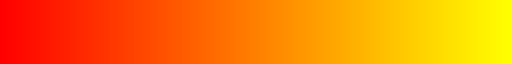

In [8]:
plt.cm.autumn

--- 

# Pair fraction

## dwarfs

### no sep cut

In [ ]:
size = "dwarf"

illd = get_paircounts("Illustris", "dark", size)
illh = get_paircounts("Illustris", "hydro", size)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size)
tngh = get_paircounts("TNG", "hydro", size)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size)
tngsim = get_paircounts_simstell("TNG", size)
print("done with stars")


#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)


axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
# axillmaj.fill_between(illsim['z'], np.array(illsim['Quarts Fraction Majors'])[:,0], np.array(illsim['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")


axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")

###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_sim.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)


axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


#############
#############
# axillmin.legend(title="Dark",loc="upper left",fontsize=16)
# axtngmin.legend(title="Hydro",loc="upper left",fontsize=16)
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_dvh_sim.png",bbox_inches='tight',facecolor="white")
plt.show()


###  < 75 sep cut

In [ ]:
size = "dwarf"
septype = "lower"
lim = 75

illd = get_paircounts("Illustris", "dark", size,sepcut=septype,lowerthan=lim)
illh = get_paircounts("Illustris", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size,sepcut=septype,lowerthan=lim)
tngh = get_paircounts("TNG", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size,sepcut=septype,lowerthan=lim)
tngsim = get_paircounts_simstell("TNG", size,sepcut=septype,lowerthan=lim)
print("done with stars")


#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio",ylim=(0,0.2))
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)


axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
# axillmaj.fill_between(illsim['z'], np.array(illsim['Quarts Fraction Majors'])[:,0], np.array(illsim['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")


axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")

###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)


axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


#############
#############
# axillmin.legend(title="Dark",loc="upper left",fontsize=16)
# axtngmin.legend(title="Hydro",loc="upper left",fontsize=16)
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_dvh_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


### < 100 sep cut

In [ ]:
size = "dwarf"
septype = "lower"
lim = 100

illd = get_paircounts("Illustris", "dark", size,sepcut=septype,lowerthan=lim)
illh = get_paircounts("Illustris", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size,sepcut=septype,lowerthan=lim)
tngh = get_paircounts("TNG", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size,sepcut=septype,lowerthan=lim)
tngsim = get_paircounts_simstell("TNG", size,sepcut=septype,lowerthan=lim)
print("done with stars")


#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio",ylim=(0,0.2))
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)


axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
# axillmaj.fill_between(illsim['z'], np.array(illsim['Quarts Fraction Majors'])[:,0], np.array(illsim['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color='black',alpha=0, label="Sim")


axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")

###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)


axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


#############
#############
# axillmin.legend(title="Dark",loc="upper left",fontsize=16)
# axtngmin.legend(title="Hydro",loc="upper left",fontsize=16)
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/committee-meeting/pairfrac_dwarf_dvh_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


## massive

### no sep cut

In [ ]:
size = "massive"

illd = get_paircounts("Illustris", "dark", size)
illh = get_paircounts("Illustris", "hydro", size)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size)
tngh = get_paircounts("TNG", "hydro", size)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size)
tngsim = get_paircounts_simstell("TNG", size)
print("done with stars")

#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)


axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
# axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
# axtngmin.legend(title="TNG",loc="upper left",fontsize=16)

for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
axillmaj.set(ylim=(0.08,0.32))
axtngmaj.set(ylim=(0.08,0.32))


fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_sim.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
# axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
# axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
# axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
# axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
# axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
# axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
# axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
# axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
# axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

#############
#############
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_dvh.png",bbox_inches='tight',facecolor="white")
# plt.savefig(f"../plots/committee-meeting/pairfrac_massive_dvh_sim.png",bbox_inches='tight',facecolor="white")
plt.show()


### < 75 sep cut

In [ ]:
size = "massive"
septype = "lower"
lim = 75

illd = get_paircounts("Illustris", "dark", size,sepcut=septype,lowerthan=lim)
illh = get_paircounts("Illustris", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size,sepcut=septype,lowerthan=lim)
tngh = get_paircounts("TNG", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size,sepcut=septype,lowerthan=lim)
tngsim = get_paircounts_simstell("TNG", size,sepcut=septype,lowerthan=lim)
print("done with stars")

#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)


axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
# axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
# axtngmin.legend(title="TNG",loc="upper left",fontsize=16)

for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
axillmaj.set(ylim=(0.04,0.32))
axtngmaj.set(ylim=(0.04,0.32))


fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

#############
#############
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_dvh_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


### < 100 sep cut

In [ ]:
size = "massive"
septype = "lower"
lim = 100

illd = get_paircounts("Illustris", "dark", size,sepcut=septype,lowerthan=lim)
illh = get_paircounts("Illustris", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size,sepcut=septype,lowerthan=lim)
tngh = get_paircounts("TNG", "hydro", size,sepcut=septype,lowerthan=lim)
print("done with tng")

illsim = get_paircounts_simstell("Illustris", size,sepcut=septype,lowerthan=lim)
tngsim = get_paircounts_simstell("TNG", size,sepcut=septype,lowerthan=lim)
print("done with stars")

#### illustris vs. tng

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)


axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")


axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
# axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
# axtngmin.legend(title="TNG",loc="upper left",fontsize=16)

for ax, tit in zip([axillmin,axtngmin],["Illustris","TNG"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
axillmaj.set(ylim=(0.04,0.32))
axtngmaj.set(ylim=(0.04,0.32))


fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


#### dark vs hydro

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(3, 2, figsize=(16,12), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,0.1,3],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[1]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axtngmaj = ax[2][0]
axtngmin = ax[2][1]

axillmaj.set(title="Major", ylabel="Pair ratio")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Pair ratio")


al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###############
# hydro major #
###############
axtngmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=3)
axtngmaj.plot(illsim['z'],illsim['Fraction Majors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


###############
# hydro minor #
###############
axtngmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(illsim['z'],illsim['Fraction Minors'], color=palette["Illustris hydro"],linestyle='dashed', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color=palette["TNG hydro"],linestyle='dashed', lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color='black',alpha=0, label="Sim")

#############
#############
for ax, tit in zip([axillmin,axtngmin],["Dark","Hydro"]):
    leg = ax.legend(loc='upper left',title=tit,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)


fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/pairfrac_massive_dvh_sim_{septype}{lim}.png",bbox_inches='tight',facecolor="white")
plt.show()


---

# Separation

## dwarfs

### No separation cut

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "Separation"
sepcut = None

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_dwarf.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")




###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_dwarf_dvh.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### Low sep cut

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "Separation"
sepcut = "low"

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_dwarf_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")




###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_dwarf_dvh_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### High sep cut

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "Separation"
sepcut = "high"

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_dwarf_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")




###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_dwarf_dvh_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

## massive

### No separation cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "Separation"
sepcut = None

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_massive.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_massive_dvh.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### Low sep cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "Separation"
sepcut = "low"

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_massive_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_massive_dvh_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### High sep cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "Separation"
sepcut = "high"

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/separation_massive_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Separations")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Separations")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/separation_massive_dvh_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

---

# Velocity

## dwarfs

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "RelVel"
sepcut = None

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


### No separation cut

#### illustris vs tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


al = 0.5

###################
# Illustris major #
###################

axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")


#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf_dvh.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### Low sep cut

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "RelVel"
sepcut = 'low'

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############

axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf_dvh_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### High sep cut

In [ ]:
# function to make major+minor sep plots
size = "dwarf"
key = "RelVel"
sepcut = 'high'

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############

axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_dwarf_dvh_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

## massive

### No separation cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "RelVel"
sepcut = None

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############

axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_massive.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_massive_dvh.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### Low sep cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "RelVel"
sepcut = 'low'

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############

axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_massive_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_massive_dvh_low.png",bbox_inches='tight',facecolor="white")
plt.show()
    

### High sep cut

In [ ]:
# function to make major+minor sep plots
size = "massive"
key = "RelVel"
sepcut = 'high'

illd = get_key("Illustris", "dark", size, key, sepcut)
illh = get_key("Illustris", "hydro", size, key, sepcut)
print("done with Illustris")

tngd = get_key("TNG", "dark", size, key, sepcut)
tngh = get_key("TNG", "hydro", size, key, sepcut)
print("done with TNG")


#### illustris vs. tng

In [ ]:
# begin major minor plot:
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]
axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]
axtngmaj = ax[3][0]
axtngmin = ax[3][1]
axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")

al = 0.5

###################
# Illustris major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############

axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/committee-meeting/velocity_massive_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

#### dark vs hydro

In [ ]:
al = 0.5

# begin major minor plot:
fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row', sharex=True, gridspec_kw={'wspace': 0.05,"hspace":0.02})

axillmaj = ax[0][0]
axillmin = ax[0][1]
axtngmaj = ax[1][0]
axtngmin = ax[1][1]

axillmaj.set(title="Major", ylabel="Relative Velocity [km/s]")
axillmin.set(title="Minor")
axtngmaj.set(ylabel="Relative Velocity [km/s]")


###################
# Dark major #
###################
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


###################
# Dark minor #
###################
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Illustris")
axillmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="TNG")


#############
# Hydro major #
#############
axtngmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)

axtngmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
# Hydro minor #
#############
axtngmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)

axtngmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Illustris")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="TNG")

#############
#############
axillmin.legend(title="Dark",loc="upper right",fontsize=16)
axtngmin.legend(title="Hydro",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.06)
plt.savefig(f"../plots/committee-meeting/velocity_massive_dvh_high.png",bbox_inches='tight',facecolor="white")
plt.show()
    

___
$\quad$

$\quad$

---

---
# Graveyard:


In [ ]:
def get_keys_simstars(sim, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
            # grabbing the relevant values
            pairs = pair_data["paired"]["hydro"]

            pri_stell = np.array(pairs["Sub1 Stellar Mass"])
            sec_stell = np.array(pairs["Sub2 Stellar Mass"])
            grouprads = np.array(pairs["Group Radius"])
            groupmass = np.array(pairs["Group Mass"])
            reals = np.array(pairs["Realization"])
            seps = np.array(pairs["Separation"]) 
            keydat = np.array(pairs[key]) 
            
            # masks            
            pair_prims = get_primmask(pri_stell, size)
            pair_group = get_groupmask(groupmass, size)
            pair_medreal = reals == -1

            majors = (sec_stell/pri_stell > 1/4)
            minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
      
            pair_mask = pair_prims & pair_group & pair_medreal & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*grouprads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*grouprads
                pair_mask = pair_mask & sep_mask

            pair_mask = pair_mask & (majors|minors) 
            major_mask = pair_mask & majors
            minor_mask = pair_mask & minors

            med_pairs_snap = np.median( keydat[pair_mask] )
            med_major_snap = np.median( keydat[major_mask] )
            med_minor_snap = np.median( keydat[minor_mask] )
            quart_pairs_snap = [0,0]
            quart_major_snap = [0,0]
            quart_minor_snap = [0,0]
                                                      
            
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )


            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

